In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find K-giant calibrators near my target

First, some imports!

In [11]:
import list_builder as lb
import availability_checker as ac
import sort_targets as st
import write_gallery as wg
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.table as at
import astropy.units as q
import astropy.coordinates as coords
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier

This is a general recipe on how to find K-giant calibrator stars near my targets. I'll use the spiral galaxy NGC1068, a high priority NIRISS/AMI commissioning target, as an example.

First, I'll store the search criteria in some variables. 

`ra` and `dec` are the center coordinates around which we will perform the search. In this case, they are the coordinates of our target NGC1068. `radius` is the radius in degrees about these centeral coordinates where we will search.

`kmag` is a tuple of the upper and lower bounds on the 2MASS K magnitude of the stars we are looking for.

`JH` and `HK` are tuples of the upper and lower bounds on the 2MASS J-H and H-K colors.

In [12]:
name = 'AMI'                      # Just a name for the search
destination = 'target_lists/'     # The relative path to the save the results to
ra, dec = 40.669879, -0.013289    # The central RA and Dec for the search
radius = 0.6                      # ...which is 40 arcminutes
kmag = (4, 7)                     # We only want stars between 4 and 7 magnitudes in K-band
JH, HK = (0.4, 0.9), (-0.1, 0.3)  # These color cuts isolate K-giants

Now we are ready to perform our search.

In [13]:
result = lb.search(kmag, ra=ra, dec=dec, radius=radius, JH=JH, HK=HK, name=name, list_subdir=destination)

[MainProcess:2016-12-21T14:36:58.527609] Computing AMI from {'color_cuts': {'H-K': (-0.1, 0.3), 'J-H': (0.4, 0.9)},
 'k_mag': (4, 7),
 'location': {'dec': -0.013289, 'ra': 40.669879, 'radius': 0.6},
 'neighbors': ({'delta_k': 5.0, 'r_arcmin': 0.043},)}
[MainProcess:2016-12-21T14:36:58.528042] ./query_2mass MK_MIN=4.0 MK_MAX=7.0 RA_CEN=40.669879 DE_CEN=-0.013289 DR_MIN=0.001 DR_MAX=0.6 > cache/base_4.0_k_7.0
[ForkPoolWorker-1:2016-12-21T14:37:03.112082] neighbor searching cache/base_4.0_k_7.0_good_0.4_JH_0.9_-0.1_HK_0.3.chunk_00001
[ForkPoolWorker-1:2016-12-21T14:37:03.114469] args: ('cache/base_4.0_k_7.0_good_0.4_JH_0.9_-0.1_HK_0.3.chunk_00001', 5.0, 0.043, 'cache/base_4.0_k_7.0_good_0.4_JH_0.9_-0.1_HK_0.3_without_neighbors_r_0.00072_dk_5.0', <AcquirerProxy object, typeid 'Lock' at 0x112dcb4a8>, False, False, False)
[ForkPoolWorker-1:2016-12-21T14:37:03.116689] ./query_2mass RDLIST+ DR_MIN=0.001 DR_MAX=0.00072 DK_MAX=5.0 < cache/base_4.0_k_7.0_good_0.4_JH_0.9_-0.1_HK_0.3.chunk_00001 > 

In [14]:
result

RA,Dec,J,H,K,qual,idx,delta_RA,delta_Dec,J-H,H-K,arcmin
float64,float64,float64,float64,float64,str3,str9,float64,float64,float64,float64,float64
41.23526,-0.00362,7.03,6.44,6.36,AAA,U00000001,0.5654,0.00966,0.59,0.08,33.928
40.93783,0.21037,7.16,6.57,6.4,AAA,U00000003,0.26795,0.22367,0.59,0.17,20.942
40.82145,0.08726,6.19,5.46,5.23,AAA,U00000002,0.15157,0.10055,0.73,0.23,10.913


We found three potential K-giants within 40 arcminutes of NGC1068! The last column is the distance from the central RA and Dec in arcminutes.

Next we need to check the availability of our targets based on their visibility with JWST.

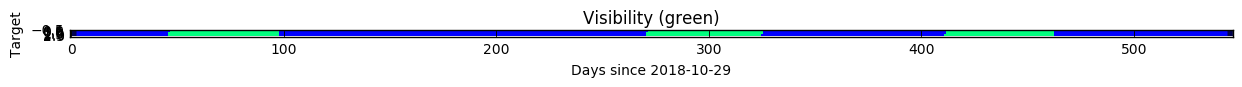

In [15]:
# Run through visibility_checker and check to see that the neighborhood is clear of other objects 
anim = ac.analyze_catalog(destination+name, None, lite=True, kind='')

# Plot the availability over the year
avail_data = np.load(destination+name+'_avail.npy')
plt.figure(figsize=(15,10))
plt.imshow(avail_data, cmap=matplotlib.cm.winter, interpolation='none')
plt.xlabel('Days since 2018-10-29')
plt.ylabel('Target')
plt.title('Visibility (green)')

As expected given our search radius, our three K-giants are visible all at the same time, shown in green.

With larget target lists having scattered viewing times, we would want to sort our targets based on their visibility. For this example, we expect no difference after sorting since the targets all have similar viewing conditions. 

Still, let's run it just so we cover all the steps.

In [16]:
!python sort_targets.py ./target_lists/AMI ./target_lists/AMI_avail.npy --min_per_day_hemi=4 --max_length=8

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659    0  1292  100  1367    117    124  0:00:11  0:00:10  0:00:01     0


Finally, let's take a look at the targets in the DSS and 2MASS Point Source Catalogs. 

First we will retrieve the 2MASS IDs from IRSA, then the spectral type from Simbad, then check the Washington Double Star Catalog to make sure it is not a binary.

In [ ]:
IDs = []
for row in result:
    r, d = row['RA'], row['Dec']
    print('Fetching 2MASS ID for source at',r,d,'...')
    source = Irsa.query_region(coords.ICRS(ra=r*q.deg, dec=d*q.deg), radius=2.0*q.arcsec, catalog=['fp_psc'])
    twomass = source['designation'][0].decode("utf-8")
    
    # Checking [Skiff, SEGUE, Michigan Spectral Survey]
    catalogs = ['B/mk/mktypes','J/ApJ/816/80/table3','III/214/vol5']
    MK = Vizier.query_region(coords.ICRS(ra=r*q.deg, dec=d*q.deg), radius=2.0*q.arcsec, catalog=catalogs)

    try:
        spts = [i.decode("utf-8") for i in MK[0]['SpType']]
        
        for spt in spts:
            if 'K' in spt and 'III' in spt:
                print(twomass,'is a',spt,'. Checking multiplicity...')
                
                wds = Vizier.query_region(coords.ICRS(ra=r*q.deg, dec=d*q.deg), radius=2.0*q.arcsec, catalog=('B/wds/wds'))
                
                if wds:
                    print(twomass,'is a binary! Sorry.')
                else:
                    print(twomass,'is a single K-giant! Adding it to the list.')
                    IDs.append(twomass)
                    break
            else:
                print(twomass,'is not a K-giant:',spt)
    except IOError:
        print('No spectral type for source',twomass)
    print('\r')

print('Done!',len(IDs),'candidate{} found.'.format('s' if len(IDs) else ''))

Fetching 2MASS ID for source at 41.23526 -0.00362 ...


In [8]:
Vizier.find_catalogs()

TypeError: find_catalogs() missing 1 required positional argument: 'keywords'

Now we can get the postage stamps for the objects. In this case, only one K-giant was found... but that's all we need!

In [63]:
wg.gallery(IDs, 'target_lists/Cutouts.html')
!open target_lists/Cutouts.html

FIN